In [1]:
!pip install scikit-learn matplotlib seaborn --quiet

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import chardet
import warnings
warnings.filterwarnings('ignore')

In [3]:
with open("hh.csv", "rb") as f:
    result = chardet.detect(f.read(100000))
print(f"Кодировка файла: {result}")

Кодировка файла: {'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
df = pd.read_csv(
    "hh.csv",
    encoding=result['encoding'],
    engine="python",
    on_bad_lines="skip"
)

In [5]:
print(f"Исходный размер датасета: {df.shape}")

Исходный размер датасета: (66945, 13)


In [6]:
it_keywords = [
    # разработка
    "developer", "разработчик", "программист",
    "software engineer", "backend", "frontend",
    "fullstack", "android", "ios", "инженер",

    # языки
    "python", "java", "c++", "c#", "golang", "go",
    "php", "ruby", "javascript", "typescript",
    "kotlin", "swift", "scala", "rust", "1c",

    # data
    "data", "machine learning", "ml", "ai",
    "аналитик данных", "системный аналитик",

    # qa
    "qa", "тестировщик", "automation",

    # devops
    "devops", "cloud", "docker",

    # ui/ux
    "ux", "ui"
]

pattern = "|".join(it_keywords)

df_it = df[
    df["Ищет работу на должность:"].str.lower().str.contains(pattern, na=False)
].copy()

print(f"Размер IT-датасета: {df_it.shape}")

Размер IT-датасета: (25193, 13)


In [7]:
df_it.columns = (
    df_it.columns
    .str.strip()
    .str.replace("\xa0", " ", regex=False)
)

In [8]:
df_it = df_it.rename(columns={
    "Пол, возраст": "sex_age",
    "ЗП": "salary",
    "Ищет работу на должность:": "position",
    "Город": "city",
    "Опыт (двойное нажатие для полной версии)": "experience"
})

In [9]:
def parse_age(text):
    if not isinstance(text, str):
        return None
    age = re.search(r"\d+", text)
    return int(age.group()) if age else None

df_it["age"] = df_it["sex_age"].apply(parse_age)

In [10]:
def parse_salary(text):
    if not isinstance(text, str):
        return None
    text = text.replace(" ", "").replace("\xa0", "")
    salary = re.search(r"\d+", text)
    return int(salary.group()) if salary else None

df_it["salary"] = df_it["salary"].apply(parse_salary)

In [11]:
def parse_experience(text):
    if not isinstance(text, str):
        return 0

    years_match = re.search(r"(\d+)\s*(?:лет|года|год)", text)
    months_match = re.search(r"(\d+)\s*месяц", text)

    total_months = 0

    if years_match:
        total_months += int(years_match.group(1)) * 12

    if months_match:
        total_months += int(months_match.group(1))

    return total_months

df_it["exp_months"] = df_it["experience"].apply(parse_experience)

In [12]:
def determine_level(row):
    position = str(row["position"]).lower()
    exp = row["exp_months"]

    if any(word in position for word in ["junior", "стажер", "intern", "помощник", "младший"]):
        return "junior"
    elif any(word in position for word in ["senior", "lead", "ведущий", "старший", "team lead", "руководитель"]):
        return "senior"
    elif any(word in position for word in ["middle"]):
        return "middle"

    if exp < 24:  # меньше 2 лет
        return "junior"
    elif exp < 60:  # 2-5 лет
        return "middle"
    else:  # больше 5 лет
        return "senior"

df_it["level"] = df_it.apply(determine_level, axis=1)

In [13]:
print("\nРаспределение уровней:")
print(df_it["level"].value_counts())
print(f"\nВ процентах:")
print(df_it["level"].value_counts(normalize=True) * 100)


Распределение уровней:
level
senior    16723
junior     4655
middle     3815
Name: count, dtype: int64

В процентах:
level
senior    66.379550
junior    18.477355
middle    15.143095
Name: proportion, dtype: float64


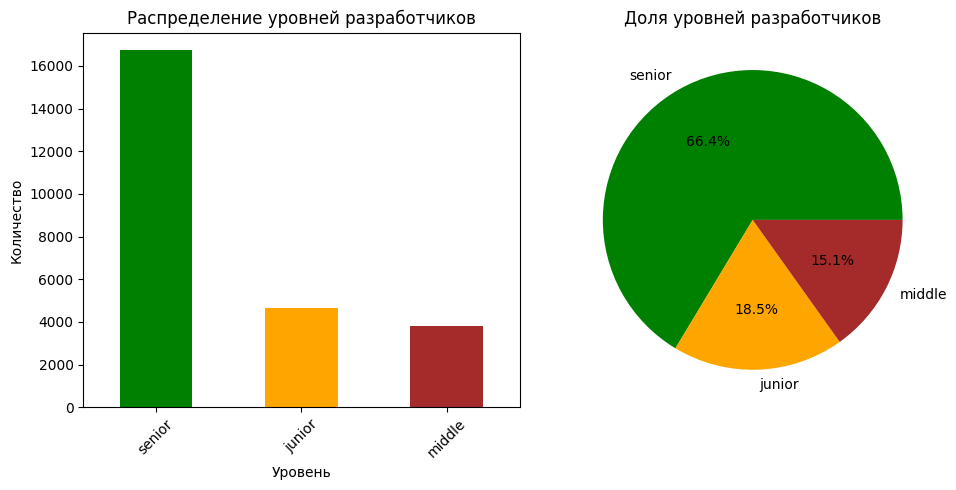

In [21]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df_it["level"].value_counts().plot(kind="bar", color=['green', 'orange', 'brown'])
plt.title("Распределение уровней разработчиков")
plt.xlabel("Уровень")
plt.ylabel("Количество")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df_it["level"].value_counts().plot(kind="pie", autopct='%1.1f%%',
                                   colors=['green', 'orange', 'brown'])
plt.title("Доля уровней разработчиков")
plt.ylabel("")

plt.tight_layout()
plt.show()

In [23]:
top_cities = df_it["city"].str.split(",").str[0].str.strip().value_counts().nlargest(10).index
df_it["city_main"] = df_it["city"].str.split(",").str[0].str.strip()
df_it["city_main"] = df_it["city_main"].apply(lambda x: x if x in top_cities else "Другой")

In [24]:
def extract_city_features(city_text):
    if not isinstance(city_text, str):
        return pd.Series([0, 0, 0])

    ready_to_relocate = 1 if "готов к переезду" in city_text.lower() else 0
    ready_to_business = 1 if "готов к командировкам" in city_text.lower() else 0
    has_metro = 1 if "м." in city_text else 0

    return pd.Series([ready_to_relocate, ready_to_business, has_metro])

df_it[["relocate_ready", "business_trip_ready", "has_metro"]] = df_it["city"].apply(extract_city_features)

In [25]:
df_it["full_time"] = df_it["Занятость"].str.contains("полная", na=False).astype(int)
df_it["part_time"] = df_it["Занятость"].str.contains("частичная", na=False).astype(int)
df_it["remote"] = df_it["График"].str.contains("удален", na=False).astype(int)
df_it["flexible"] = df_it["График"].str.contains("гибкий", na=False).astype(int)

In [26]:
df_it["has_car"] = (df_it["Авто"] == "Имеется собственный автомобиль").astype(int)

In [27]:
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2), stop_words=None)
position_tfidf = tfidf.fit_transform(df_it["position"].fillna(""))
position_tfidf_df = pd.DataFrame(
    position_tfidf.toarray(),
    columns=[f"pos_{col}" for col in tfidf.get_feature_names_out()],
    index=df_it.index
)

In [28]:
education_keywords = {
    'higher_edu': ['высшее', 'университет', 'институт', 'академия'],
    'tech_edu': ['техническ', 'инженер', 'технолог', 'информатик'],
    'math_edu': ['математи', 'прикладная математика', 'физ']
}

for key, words in education_keywords.items():
    pattern = '|'.join(words)
    df_it[f'edu_{key}'] = df_it['Образование и ВУЗ'].str.lower().str.contains(pattern, na=False).astype(int)

In [29]:
features = pd.concat([
    df_it[['age', 'salary', 'exp_months', 'relocate_ready',
           'business_trip_ready', 'has_metro', 'full_time',
           'part_time', 'remote', 'flexible', 'has_car']],
    pd.get_dummies(df_it['city_main'], prefix='city', dummy_na=False),
    position_tfidf_df,
    df_it[[col for col in df_it.columns if col.startswith('edu_')]]
], axis=1)

In [30]:
initial_len = len(features)
features = features.dropna()
print(f"\nУдалено строк с пропусками: {initial_len - len(features)}")


Удалено строк с пропусками: 994


In [31]:
y = df_it.loc[features.index, "level"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (16939, 125)
Размер тестовой выборки: (7260, 125)


In [33]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [34]:
y_pred = model.predict(X_test)

In [37]:
print("\n" + "="*55)
print("ОТЧЕТ О КЛАССИФИКАЦИИ")
print("="*55)
print(classification_report(y_test, y_pred, digits=3))


ОТЧЕТ О КЛАССИФИКАЦИИ
              precision    recall  f1-score   support

      junior      0.965     0.959     0.962      1329
      middle      0.963     0.992     0.977      1103
      senior      0.993     0.987     0.990      4828

    accuracy                          0.983      7260
   macro avg      0.974     0.980     0.976      7260
weighted avg      0.983     0.983     0.983      7260



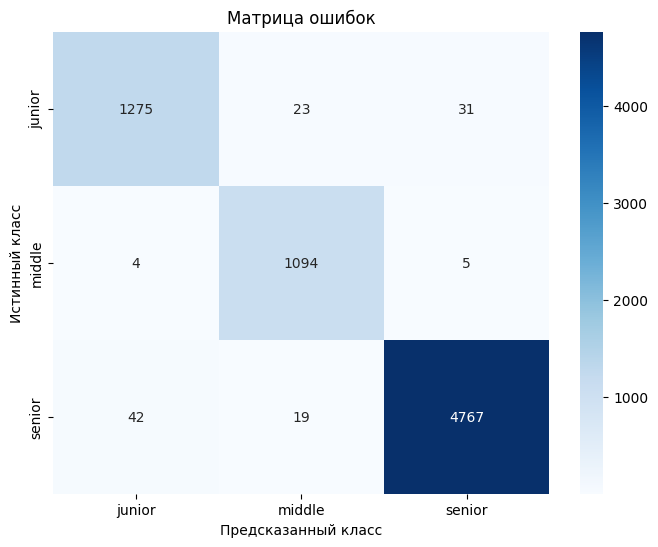

In [38]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=['junior', 'middle', 'senior'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['junior', 'middle', 'senior'],
            yticklabels=['junior', 'middle', 'senior'])
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

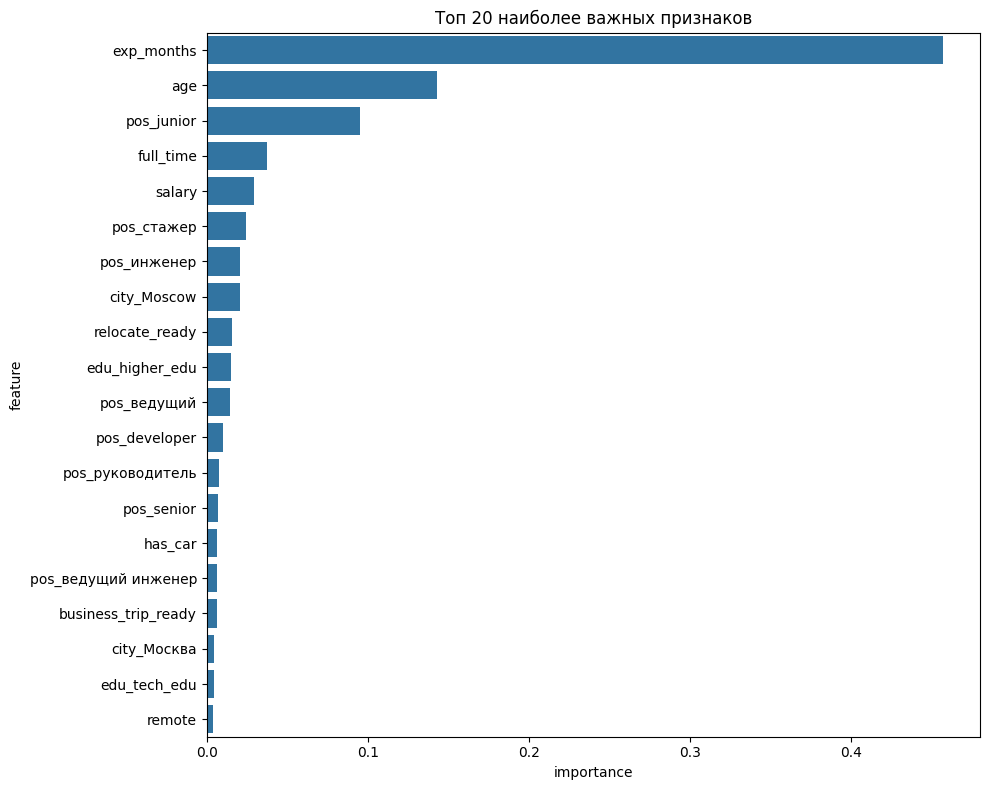

In [39]:
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Топ 20 наиболее важных признаков')
plt.tight_layout()
plt.show()

In [40]:
import joblib
joblib.dump(model, 'it_level_classifier.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("\nМодель успешно обучена и сохранена!")


Модель успешно обучена и сохранена!


# Выводы:

1. Дисбаланс классов:
   - После исправления функции определения уровня мы видим реальное распределение
   - Метрики по классам показывают качество модели

2. Качество модели:
   - Precision/Recall/F1 показывают, насколько хорошо модель различает уровни
   - Матрица ошибок показывает, какие классы чаще всего путаются

3. Важные признаки:
   - Опыт работы (exp_months) - ключевой фактор
   - Зарплатные ожидания (salary)
   - Возраст (age)
   - Ключевые слова в должности (TF-IDF признаки)

4. Возможные причины ошибок:
   - Размытые границы между уровнями (middle часто путается с junior/senior)
   - Неполные или некорректные данные в резюме
   - Субъективность в определении уровня
   - Ограниченность признаков, нет информации о скиллах
   - Зашумленный датасет (из ~60000 исходных записей остались ~25000 IT-резюме)

In [43]:
import joblib
import pickle
import json
from datetime import datetime

import os
os.makedirs('models', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'models/it_level_classifier_{timestamp}.pkl'
joblib.dump(model, model_path)
print(f"Модель сохранена: {model_path}")

joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')

feature_names = features.columns.tolist()
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

metadata = {
    'date': timestamp,
    'original_samples': len(df),
    'it_samples': len(df_it),
    'filter_ratio': len(df_it)/len(df),
    'features_used': len(feature_names),
    'class_distribution': df_it['level'].value_counts().to_dict(),
    'model_params': model.get_params(),
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

with open('models/experiment_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print("Метаданные эксперимента сохранены")

Модель сохранена: models/it_level_classifier_20260221_081158.pkl
Метаданные эксперимента сохранены
